# BC Covid19 case details
-- This is a project that is still in progress  

![](./Comparison_Of_COVID-19_Cases_across_regions.png)

web source  
https://catalogue.data.gov.bc.ca/dataset/b-c-covid-19-case-details/resource/53630e95-26d9-4cff-8740-383a78a55917
https://api.covid19tracker.ca/docs/1.0/overview

data source    
Cases URL: http://www.bccdc.ca/Health-Info-Site/Documents/BCCDC_COVID19_Dashboard_Case_Details.csv  
Vaccination & Recovery URL: https://docs.google.com/spreadsheets/d/1PjkemMdFSZgA-M8Esr6rbNjHiyfcXcBxPeMjselJIso/edit?usp=sharing

In [1]:
import pandas as pd
import math
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
import urllib
from datetime import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

In [2]:
caseDetailsUrl = 'http://www.bccdc.ca/Health-Info-Site/Documents/BCCDC_COVID19_Dashboard_Case_Details.csv'
vaccinationsUrl = 'https://docs.google.com/spreadsheets/d/1PjkemMdFSZgA-M8Esr6rbNjHiyfcXcBxPeMjselJIso/edit?usp=sharing'

In [3]:
df = pd.read_csv(caseDetailsUrl)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142636 entries, 0 to 142635
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Reported_Date            142636 non-null  object
 1   HA                       142636 non-null  object
 2   Sex                      142636 non-null  object
 3   Age_Group                142636 non-null  object
 4   Classification_Reported  142636 non-null  object
dtypes: object(5)
memory usage: 5.4+ MB


In [5]:
df.rename(columns={'Reported_Date':'Reported Date', 'HA': 'Health Authority', 'Age_Group': 'Age Group', 'Classification_Reported': 'Classification Reported'}, inplace=True)

In [6]:
df['Reported Date'] = pd.to_datetime(df['Reported Date'])

In [7]:
df.head()

,Reported Date,Health Authority,Sex,Age Group,Classification Reported
0,2020-01-29,Out of Canada,M,40-49,Lab-diagnosed
1,2020-02-06,Vancouver Coastal,F,50-59,Lab-diagnosed
2,2020-02-10,Out of Canada,F,20-29,Lab-diagnosed
3,2020-02-10,Out of Canada,M,30-39,Lab-diagnosed
4,2020-02-18,Interior,F,30-39,Lab-diagnosed


In [8]:
df.shape

(142636, 5)

In [9]:
lastRow = int(df.shape[0])-1

In [10]:
totalDays = df.loc[lastRow, 'Reported Date'] - df.loc[0, 'Reported Date']
firstReported = df['Reported Date'].min()
latestReported = df['Reported Date'].max()

In [11]:
# check the oldest and latest record
print(f'This data is for a period between {firstReported.strftime("%d %B %Y")} and {latestReported.strftime("%d %B %Y")}')
print(f"For a total of {totalDays.days} days")

This data is for a period between 29 January 2020 and 24 May 2021
For a total of 481 days


In [12]:
df['Classification Reported'].unique()

array(['Lab-diagnosed', 'Epi-linked'], dtype=object)

In [13]:
df['Diagnosed'] = np.where(df['Classification Reported'] == df['Classification Reported'].unique()[0], 1,
                          np.where(df['Classification Reported'] == df['Classification Reported'].unique()[1], np.nan, np.nan))

In [14]:
df.head()

,Reported Date,Health Authority,Sex,Age Group,Classification Reported,Diagnosed
0,2020-01-29,Out of Canada,M,40-49,Lab-diagnosed,1.0
1,2020-02-06,Vancouver Coastal,F,50-59,Lab-diagnosed,1.0
2,2020-02-10,Out of Canada,F,20-29,Lab-diagnosed,1.0
3,2020-02-10,Out of Canada,M,30-39,Lab-diagnosed,1.0
4,2020-02-18,Interior,F,30-39,Lab-diagnosed,1.0


In [15]:
df['Diagnosed'].count()

141553

In [16]:
df.groupby(pd.Grouper(key='Reported Date',freq='M'))['Diagnosed'].count()

Reported Date
2020-01-31        1
2020-02-29        6
2020-03-31     1074
2020-04-30     1069
2020-05-31      442
2020-06-30      329
2020-07-31      733
2020-08-31     2154
2020-09-30     3294
2020-10-31     5990
2020-11-30    19064
2020-12-31    18376
2021-01-31    14836
2021-02-28    12842
2021-03-31    19830
2021-04-30    29334
2021-05-31    12179
Freq: M, Name: Diagnosed, dtype: int64

In [17]:
df.set_index('Reported Date').groupby(pd.Grouper(freq='D'))['Diagnosed'].count()

Reported Date
2020-01-29      1
2020-01-30      0
2020-01-31      0
2020-02-01      0
2020-02-02      0
             ... 
2021-05-20    436
2021-05-21    353
2021-05-22    336
2021-05-23    298
2021-05-24    247
Freq: D, Name: Diagnosed, Length: 482, dtype: int64

In [18]:
df.groupby(['Reported Date','Health Authority', 'Sex'])['Diagnosed'].count().reset_index()

,Reported Date,Health Authority,Sex,Diagnosed
0,2020-01-29,Out of Canada,M,1
1,2020-02-06,Vancouver Coastal,F,1
2,2020-02-10,Out of Canada,F,1
3,2020-02-10,Out of Canada,M,1
4,2020-02-18,Interior,F,1
...,...,...,...,...
3836,2021-05-24,Northern,M,4
3837,2021-05-24,Vancouver Coastal,F,25
3838,2021-05-24,Vancouver Coastal,M,28
3839,2021-05-24,Vancouver Island,F,3


In [19]:
currentDatePlusMonth = datetime.now() + relativedelta(days=+40)

In [20]:
print(f'{currentDatePlusMonth.strftime("%d %B %Y")}')

05 July 2021


In [21]:
forMax = df.groupby(pd.Grouper(key='Reported Date',freq='D'))['Diagnosed'].count()
forMax.idxmax().strftime("%B %Y"), forMax[forMax.idxmax()], forMax.idxmin().strftime("%B %Y"), forMax[forMax.idxmin()]
forMax.idxmax().month, forMax.idxmax().year, forMax[forMax.idxmax()], forMax.idxmin().month, forMax.idxmin().year, forMax[forMax.idxmin()]
# forMax = df.groupby(pd.Grouper(key='Reported Date',freq='1W'))['Diagnosed'].count()
# forMax.idxmax().strftime("%B %Y"), forMax[forMax.idxmax()], forMax.idxmin().strftime("%B %Y"), forMax[forMax.idxmin()]
# forMax.idxmax().month, forMax.idxmax().year, forMax[forMax.idxmax()], forMax.idxmin().month, forMax.idxmin().year, forMax[forMax.idxmin()]

(4, 2021, 1315, 1, 2020, 0)

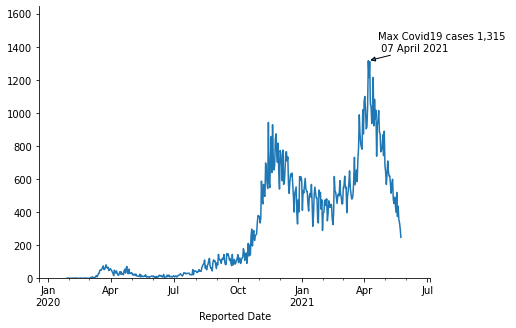

In [22]:
fig, ax = plt.subplots(figsize=(7,5)) 
fig = df.groupby(pd.Grouper(key='Reported Date',freq='D'))['Diagnosed'].count().plot()
fig.annotate(s=f'Max Covid19 cases {forMax[forMax.idxmax()]:,} \n \
{forMax.idxmax().strftime("%d %B %Y")}', xy=(forMax.idxmax(), forMax[forMax.idxmax()]), xytext=(10, 10),  
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
fig.set_xlim(firstReported-relativedelta(days=+40), pd.Timestamp(currentDatePlusMonth))
fig.set_ylim(forMax[forMax.idxmin()],forMax[forMax.idxmax()]+(forMax[forMax.idxmax()]*0.25))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [23]:
forMax = df.groupby(pd.Grouper(key='Reported Date',freq='M'))['Diagnosed'].count()
forMax.idxmax().strftime("%B %Y"), forMax[forMax.idxmax()], forMax.idxmin().strftime("%B %Y"), forMax[forMax.idxmin()]
forMax.idxmax().month, forMax.idxmax().year, forMax[forMax.idxmax()], forMax.idxmin().month, forMax.idxmin().year, forMax[forMax.idxmin()]

(4, 2021, 29334, 1, 2020, 1)

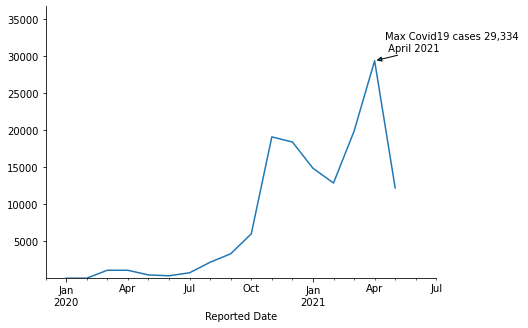

In [24]:
fig, ax = plt.subplots(figsize=(7,5)) 
fig = df.groupby(pd.Grouper(key='Reported Date',freq='M'))['Diagnosed'].count().plot()
fig.annotate(s=f'Max Covid19 cases {forMax[forMax.idxmax()]:,} \n \
{forMax.idxmax().strftime("%B %Y")}', xy=(forMax.idxmax(), forMax[forMax.idxmax()]), xytext=(10, 10),  
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
fig.set_xlim(firstReported-relativedelta(days=+40), pd.Timestamp(currentDatePlusMonth))
fig.set_ylim(forMax[forMax.idxmin()],forMax[forMax.idxmax()]+(forMax[forMax.idxmax()]*0.25))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [25]:
# BC cases over time plot

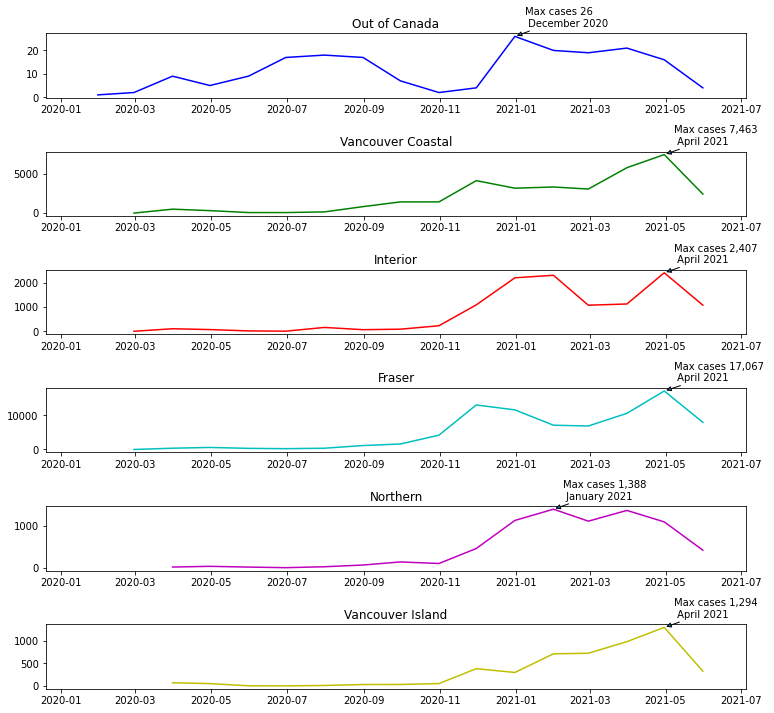

In [26]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
rows = len(df['Health Authority'].unique())
fig, axes = plt.subplots(rows, 1, figsize=(11, 10))
for HA, ax, color in zip(df['Health Authority'].unique(), axes, colors[:rows]):
    forEachHA = df[df['Health Authority'] == HA].groupby(pd.Grouper(key='Reported Date',freq='M'))['Diagnosed'].count()
    ax.plot(df[df['Health Authority'] == HA].groupby(pd.Grouper(key='Reported Date',freq='M'))['Diagnosed'].count(), 
            color=color)
    ax.annotate(s=f'Max cases {forEachHA[forEachHA.idxmax()]:,} \n \
{forEachHA.idxmax().strftime("%B %Y")}', xy=(forEachHA.idxmax(), forEachHA[forEachHA.idxmax()]), xytext=(10, 10),  
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.set_xlim(firstReported-relativedelta(days=+40), pd.Timestamp(currentDatePlusMonth))
    ax.set_title(HA)
plt.tight_layout()
plt.savefig('Comparison_Of_COVID-19_Cases_across_regions.png',
            bbox_inches='tight', transparent=False)


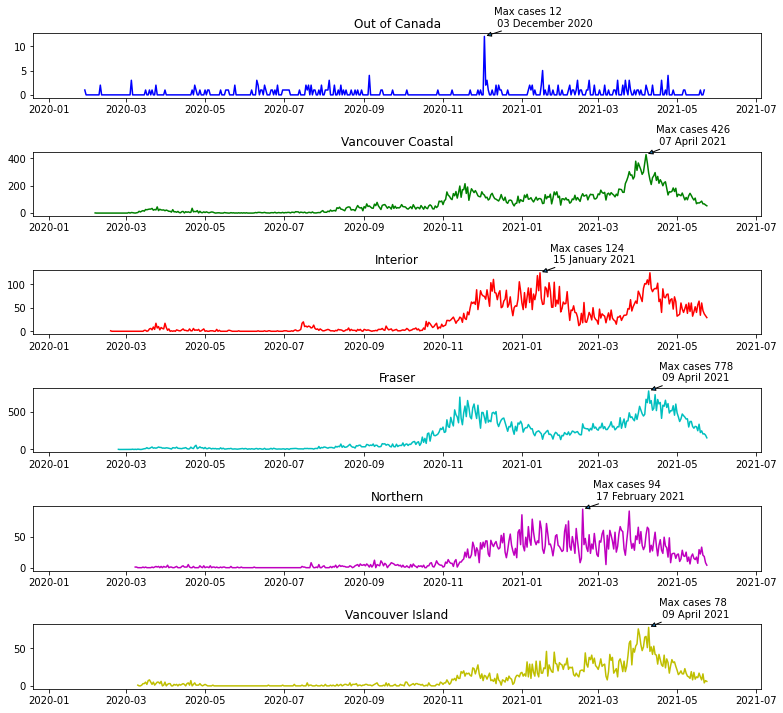

In [27]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
rows = len(df['Health Authority'].unique())
fig, axes = plt.subplots(rows, 1, figsize=(11, 10))
for HA, ax, color in zip(df['Health Authority'].unique(), axes, colors[:rows]):
    forEachHA = df[df['Health Authority'] == HA].groupby(pd.Grouper(key='Reported Date',freq='D'))['Diagnosed'].count()
    ax.plot(df[df['Health Authority'] == HA].groupby(pd.Grouper(key='Reported Date',freq='D'))['Diagnosed'].count(), 
            color=color)
    ax.annotate(s=f'Max cases {forEachHA[forEachHA.idxmax()]:,} \n \
{forEachHA.idxmax().strftime("%d %B %Y")}', xy=(forEachHA.idxmax(), forEachHA[forEachHA.idxmax()]), xytext=(10, 10),  
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.set_xlim(firstReported-relativedelta(days=+40), pd.Timestamp(currentDatePlusMonth))
    ax.set_title(HA)
plt.tight_layout()


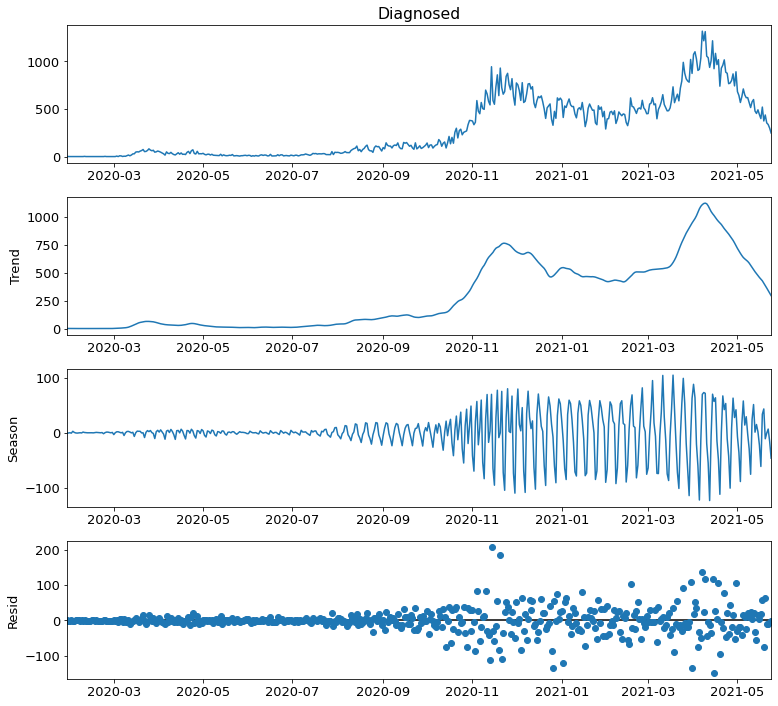

In [28]:
plt.rc('figure',figsize=(11,10))
plt.rc('font',size=13)
stl = STL(df.groupby(pd.Grouper(key='Reported Date',freq='D'))['Diagnosed'].count(), seasonal=13)
res = stl.fit()
fig = res.plot()

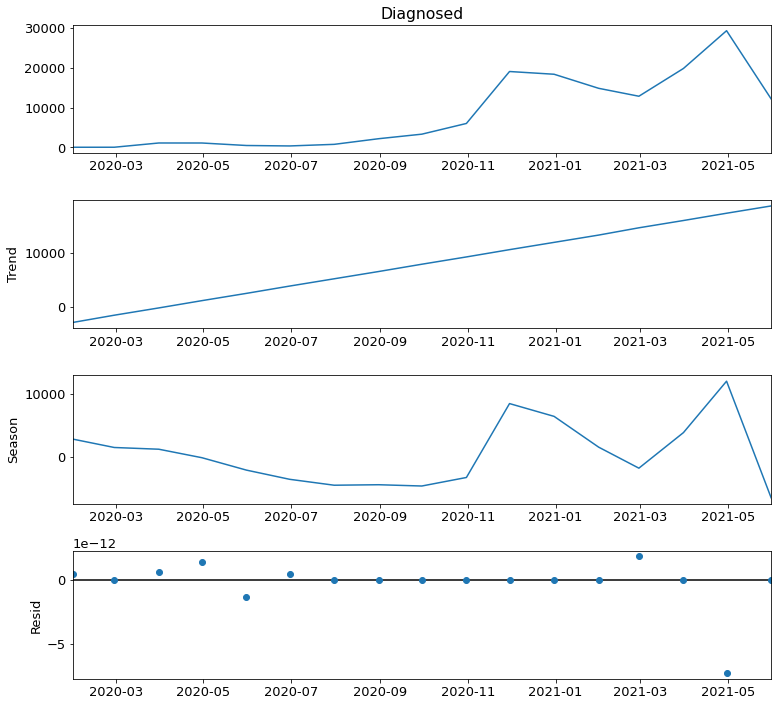

In [29]:
plt.rc('figure',figsize=(11,10))
plt.rc('font',size=13)
stl = STL(df.groupby(pd.Grouper(key='Reported Date',freq='M'))['Diagnosed'].count(), seasonal=13)
res = stl.fit()
fig = res.plot()

In [30]:
df.head()

,Reported Date,Health Authority,Sex,Age Group,Classification Reported,Diagnosed
0,2020-01-29,Out of Canada,M,40-49,Lab-diagnosed,1.0
1,2020-02-06,Vancouver Coastal,F,50-59,Lab-diagnosed,1.0
2,2020-02-10,Out of Canada,F,20-29,Lab-diagnosed,1.0
3,2020-02-10,Out of Canada,M,30-39,Lab-diagnosed,1.0
4,2020-02-18,Interior,F,30-39,Lab-diagnosed,1.0


In [31]:
sex = df.groupby(['Health Authority', 'Sex'])['Sex'].count()
ageSex = df.groupby(['Health Authority','Age Group', 'Sex'])['Sex'].count()

In [32]:
sex

Health Authority   Sex
Fraser             F      40468
                   M      42678
                   U         79
Interior           F       6070
                   M       6051
Northern           F       3841
                   M       3759
                   U          3
Out of Canada      F         21
                   M        168
                   U          9
Vancouver Coastal  F      16336
                   M      18059
                   U         76
Vancouver Island   F       2406
                   M       2604
                   U          8
Name: Sex, dtype: int64

In [33]:
sexDf = sex.unstack().reset_index()
ageSexDf = ageSex.unstack().reset_index()

In [34]:
sexDf

Sex,Health Authority,F,M,U
0,Fraser,40468.0,42678.0,79.0
1,Interior,6070.0,6051.0,NaN
2,Northern,3841.0,3759.0,3.0
3,Out of Canada,21.0,168.0,9.0
4,Vancouver Coastal,16336.0,18059.0,76.0
5,Vancouver Island,2406.0,2604.0,8.0


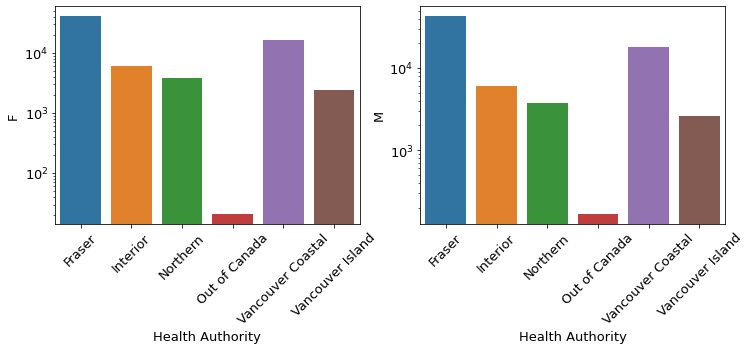

In [35]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
snsFemale = sns.barplot(x=sexDf['Health Authority'], y=sexDf['F'], ax=axes[0])
snsMale = sns.barplot(x=sexDf['Health Authority'], y=sexDf['M'], ax=axes[1])
snsFemale.set_yscale("log")
snsMale.set_yscale("log")
axes[0].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='x', labelrotation=45)
plt.show()